# Random Forest
In the following notebook, we will be using the Random Forest algorithm to build a model for the VOC CGMS readings.

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
#get data
raw = pd.read_csv('../data/cleaned/long.csv')
filled = raw.fillna(0)

## Evaluating the Model with different bootstrapping sample sizes

In [3]:
sample_size = pd.DataFrame(columns=["mean","std"])

>0.1 0.557 (0.200) (1.275)


>0.2 0.678 (0.132) (1.029)


>0.3 0.736 (0.135) (0.910)
>0.4 0.739 (0.188) (0.723)


>0.5 0.799 (0.128) (0.602)
>0.6 0.821 (0.122) (0.522)


>0.7 0.854 (0.136) (0.471)
>0.8 0.807 (0.138) (0.428)


>0.9 0.856 (0.128) (0.394)
>1.0 0.846 (0.130) (0.365)


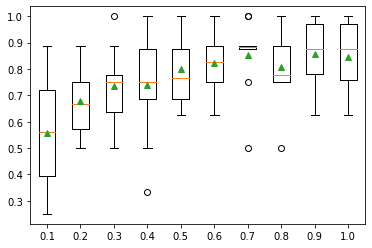

In [4]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i, max_features='sqrt')
	return models
 
# evaluate a given model using cross-validation

def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = KFold(n_splits=10, shuffle=True, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = filled.iloc[:,3:], filled.iloc[:,1]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, times = list(), list(), list()
for name, model in models.items():
	# evaluate the model
	start = time.time()
	scores = evaluate_model(model, X, y)
	end = time.time()
	# store the results
	times.append(end-start)
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	s = pd.Series(data=[np.mean(scores), np.std(scores), np.mean(times)],name=name, index=['mean','std', 'time'])
	sample_size = sample_size.append(s)
	print('>%s %.3f (%.3f) (%.3f)' % (name, np.mean(scores), np.std(scores), np.mean(times)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [5]:
#find average of all stored results
avg_sample_size = pd.DataFrame(columns=['mean', 'std', 'time'])
for i in np.arange(0.1, 1.1, 0.1):
    i = str(i)
    i = i[0: 3]
    s = pd.Series(sample_size.T[i][0], name=i, index=['mean','std','time'])
    avg_sample_size = avg_sample_size.append(s)

In [6]:
avg_sample_size.sort_values(by='mean', ascending=0).head(7)

,mean,std,time
0.9,0.855556,0.855556,0.855556
0.7,0.854167,0.854167,0.854167
1.0,0.845833,0.845833,0.845833
0.6,0.820833,0.820833,0.820833
0.8,0.806944,0.806944,0.806944
0.5,0.798611,0.798611,0.798611
0.4,0.738889,0.738889,0.738889


In [7]:
avg_sample_size.to_csv('../data/cleaned/rnd_forest/avg_sample_size.csv', index=True)

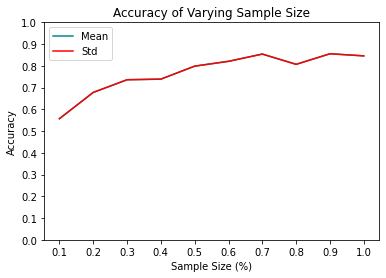

In [8]:
line1 = plt.plot(avg_sample_size.index, avg_sample_size['mean'], label='Mean', c='darkcyan')
line2 = plt.plot(avg_sample_size.index, avg_sample_size['std'], c='red', label='Std')
plt.title('Accuracy of Varying Sample Size')
plt.xlabel('Sample Size (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.yticks(ticks=np.arange(0,1.1,0.1))

plt.savefig('../images/rnd_forest/vary_sample_size.png')
plt.show()

## Evaluating the Model with different Feature selection sizes (random subspace method)

In [9]:
avg_scores_k_fold = pd.DataFrame(columns=["mean","std","time"])

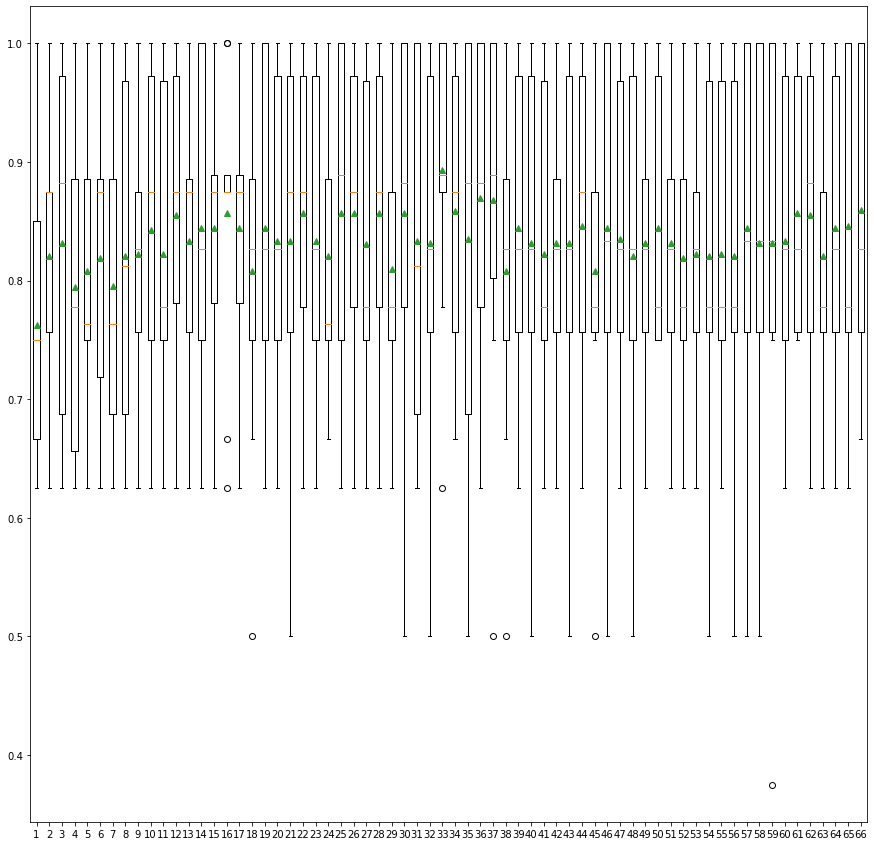

In [10]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,67):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = KFold(n_splits=10, shuffle=True, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = filled.iloc[:,3:], filled.iloc[:,1]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, times = list(), list(), list()
for name, model in models.items():
	# evaluate the model
	start = time.time()
	scores = evaluate_model(model, X, y)
	end = time.time()
	# store the results
	times.append(end-start)
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	s = pd.Series(data=[np.mean(scores), np.std(scores), np.mean(times)],name=name, index=['mean','std', 'time'])
	avg_scores_k_fold = avg_scores_k_fold.append(s)

# plot model performance for comparison
plt.figure(figsize=(15,15))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [11]:
avg_avg_k_fold = pd.DataFrame(columns=['mean', 'std', 'time'])

for i in range (1,67):
    i = str(i)
    s = pd.Series(avg_scores_k_fold.T[i][0], name=i, index=['mean','std', 'time'])
    avg_avg_k_fold = avg_avg_k_fold.append(s)

In [12]:
avg_avg_k_fold.sort_values(by='mean', ascending=0)

,mean,std,time
33,0.893056,0.893056,0.893056
36,0.869444,0.869444,0.869444
37,0.868056,0.868056,0.868056
66,0.859722,0.859722,0.859722
34,0.858333,0.858333,0.858333
...,...,...,...
5,0.808333,0.808333,0.808333
18,0.808333,0.808333,0.808333
7,0.795833,0.795833,0.795833
4,0.794444,0.794444,0.794444


In [13]:
avg_avg_k_fold.to_csv('../data/cleaned/rnd_forest/avg_vary_feat.csv', index=True)

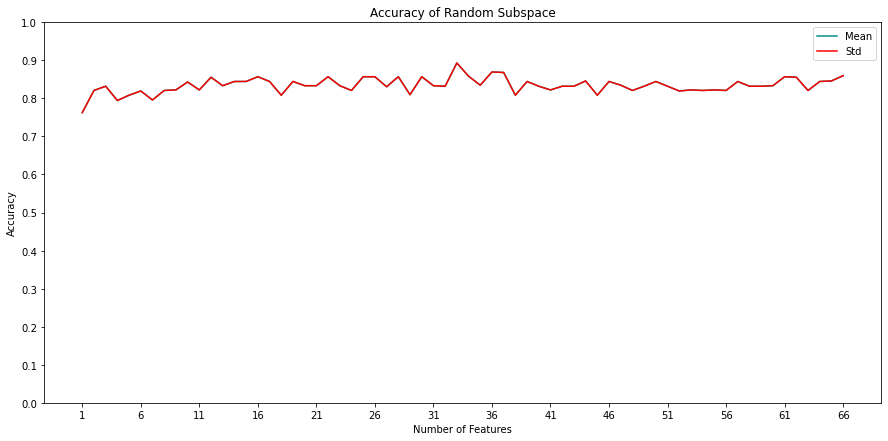

In [14]:
plt.figure(figsize=(15,7))
line1 = plt.plot(avg_avg_k_fold.index, avg_avg_k_fold['mean'], label='Mean', c='darkcyan')
line2 = plt.plot(avg_avg_k_fold.index, avg_avg_k_fold['std'], c='red', label='Std')
plt.title('Accuracy of Random Subspace')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.yticks(ticks=np.arange(0,1.1,0.1))
plt.xticks(ticks=np.arange(0,66,5))
plt.savefig('../images/rnd_forest/vary_features.png')
plt.show()

## Different number of trees

In [15]:
diff_trees = pd.DataFrame(columns=["mean","std", "time"])

>10 0.749 (0.126) (0.121)
>50 0.787 (0.114) (0.151)


>100 0.792 (0.115) (0.181)


>150 0.787 (0.154) (0.218)


>200 0.794 (0.129) (0.266)


>250 0.779 (0.118) (0.312)


>300 0.819 (0.099) (0.356)


>350 0.817 (0.090) (0.407)


>400 0.814 (0.106) (0.458)


>450 0.812 (0.102) (0.507)


>500 0.800 (0.111) (0.559)


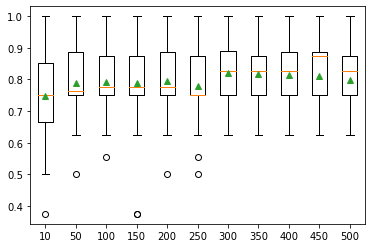

In [16]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = filled.iloc[:,3:], filled.iloc[:,1]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, times = list(), list(), list()
for name, model in models.items():
	# evaluate the model
	start = time.time()
	scores = evaluate_model(model, X, y)
	end = time.time()
	# store the results
	times.append(end-start)
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	s = pd.Series(data=[np.mean(scores), np.std(scores), np.mean(times)],name=name, index=['mean','std', 'time'])
	diff_trees = diff_trees.append(s)
	print('>%s %.3f (%.3f) (%.3f)' % (name, np.mean(scores), np.std(scores), np.mean(times)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [17]:
avg_diff_trees = pd.DataFrame(columns=['mean', 'std', 'time'])
for i in [10, 50, 100, 150, 200, 250, 350, 400, 450, 500]:
    i = str(i)
    s = pd.Series(diff_trees.T[i][0], name=i, index=['mean','std', 'time'])
    avg_diff_trees = avg_diff_trees.append(s)

In [18]:
avg_diff_trees.sort_values(by='mean', ascending=0).head(10)

,mean,std,time
350,0.816667,0.816667,0.816667
400,0.814352,0.814352,0.814352
450,0.811574,0.811574,0.811574
500,0.799537,0.799537,0.799537
200,0.794444,0.794444,0.794444
100,0.792130,0.792130,0.792130
50,0.787500,0.787500,0.787500
150,0.787500,0.787500,0.787500
250,0.779167,0.779167,0.779167
10,0.748611,0.748611,0.748611


In [19]:
avg_diff_trees.to_csv('../data/cleaned/rnd_forest/avg_vary_trees.csv', index=True)

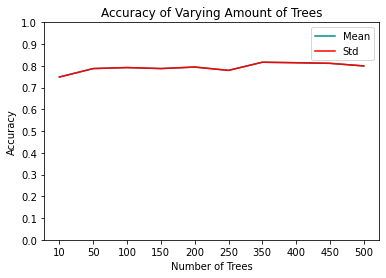

In [20]:
line1 = plt.plot(avg_diff_trees.index, avg_diff_trees['mean'], label='Mean', c='darkcyan')
line2 = plt.plot(avg_diff_trees.index, avg_diff_trees['std'], c='red', label='Std')
plt.title('Accuracy of Varying Amount of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.yticks(ticks=np.arange(0,1.1,0.1))

plt.savefig('../images/rnd_forest/vary_trees.png')
plt.show()

## Best Model
So from the above experimentation we can deduce that the best model has:
1. bootstrap sample size = 100% (all)
2. number of features = 25, or 50, ??
3. number of trees = 100

For this particular model, the best performance is recorded when the boostrap sample size is 100% of the size of the training data. Similarly to the Extra Trees model, there is ambiguity surrounding the correct amount of features to use. Selecting from 1 up to 13 features produce the lower results for the mean (by a marginal amount). The number of trees to be used remains at the default of 100. The inrease in accuracy beyond 100 trees can be attributed to statistical noise. Accuracy plateaus beyond 100 trees.

In [21]:
final_results = pd.DataFrame(columns=['mean accuracy', 'mean std'])

In [22]:
final_model = RandomForestClassifier(n_estimators=100, max_features=8, max_samples=1.0)

# define dataset
X, y = filled.iloc[:,3:], filled.iloc[:,1]

results, names = list(), list()
for i in range(50):
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    s = pd.Series(data=[np.mean(scores), np.std(scores)],name=name, index=['mean accuracy','mean std'])
    final_results = final_results.append(s)

KeyboardInterrupt: 

In [23]:
final_results.mean()

mean accuracy    0.801519
mean std         0.109014
dtype: float64